<h1>Data Analytics AI Agent</h1>

In [ ]:
%pip install langchain langgraph pandas python-dotenv duckdb numpy

In [ ]:
import pandas as pd
import numpy as np
import duckdb
import json
from typing import TypedDict, Optional, List, Dict, Union, Any
from langchain_openai import ChatOpenAI
from langchain.agents import create_react_agent, AgentExecutor
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate
from IPython.display import display

import os

from dotenv import load_dotenv
_ = load_dotenv()

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [3]:
def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Robust preprocessing of DataFrame to handle empty values."""
    # Convert empty strings and whitespace to None
    df = df.replace(r'^\s*$', None, regex=True)
    # Convert NaN strings to None
    df = df.replace(['nan', 'NaN', 'null'], None)
    # Convert pandas NaN to None
    df = df.where(pd.notnull(df), None)
    return df

# Tool definitions with single string input
@tool
def preview_excel_structure(input_str: str) -> str:
    """Use this first to examine the Excel file structure and data types. 
    The input should be a JSON string with format: {"file_name": "your_file.xlsx"}"""
    try:
        data = json.loads(input_str)
        file_name = data.get("file_name")
        if not file_name:
            return json.dumps({"error": "File name must be provided"})
            
        df = pd.read_excel(file_name)
        df = preprocess_dataframe(df)  # Apply preprocessing
        df_sample = df.head(3).astype(str)
        print("✅ Preview successful")
        display(df_sample)
        return json.dumps({
            "result": {
                "columns": df.columns.tolist(),
                "dtypes": df.dtypes.astype(str).to_dict(),
                "sample_rows": df_sample.to_dict(orient="records")
            }
        })
    except Exception as e:
        return json.dumps({"error": str(e)})
        

In [4]:
@tool
def simple_dataframe_query(input_str: str) -> str:
    """Use this for simple Pandas operations on the dataframe.
    The input should be a JSON string with format:
    {"file_name": "your_file.xlsx", "query": "your pandas expression"}"""
    try:
        data = json.loads(input_str)
        file_name = data.get("file_name")
        query = data.get("query")
        if not file_name or not query:
            return json.dumps({"error": "Both file_name and query must be provided"})

        print("\n🔍 Executing Pandas query:")
        print(query)

        global state  # Ensure state is accessible
        if state is not None:
            state['last_query'] = query
        
        df = pd.read_excel(file_name)
        df = preprocess_dataframe(df)  # Apply preprocessing
        result = eval(query, {"df": df, "pd": pd})
        
        if isinstance(result, pd.DataFrame):
            output = {
                "result": {
                    "columns": result.columns.tolist(),
                    "rows": result.fillna(None).to_dict(orient="records")
                }
            }
        else:
            output = {"result": str(result)}
        
        print("✅ Query successful")
        if isinstance(result, pd.DataFrame):
            display(result)
        else:
            print(result)
            
        return json.dumps(output)
    except Exception as e:
        return json.dumps({"error": str(e)})

In [5]:
@tool
def complex_duckdb_query(input_str: str) -> str:
    """Use this for complex SQL operations (GROUP BY, aggregations, etc.).
    The input should be a JSON string with format: 
    {"file_name": "your_file.xlsx", "query": "your SQL query"}
    Note: Use 'data' as the table name in your SQL queries."""
    try:
        data = json.loads(input_str)
        file_name = data.get("file_name")
        query = data.get("query")
        if not file_name or not query:
            return json.dumps({"error": "Both file_name and query must be provided"})

        print("\n🔍 Executing DuckDB query:")
        print(query)

        # ✅ Set the last executed query in the global state
        global state  # Ensure state is accessible
        if state is not None:
            state['last_query'] = query
        # state['last_query'] = str(query)
        
        # Read and preprocess the Excel file to handle empty values
        df = pd.read_excel(file_name)
        df = preprocess_dataframe(df)  # Clean the data upfront
        
        with duckdb.connect() as con:
            # Register dataframe with a consistent table name 'data'
            con.register("data", df)
            result = con.execute(query).fetchdf()
            print("✅ Query successful")
            display(result)
            
            # Handle different types of results robustly
            if result is None:
                return json.dumps({"result": None})
                
            if isinstance(result, pd.DataFrame):
                # Handle DataFrame results
                try:
                    # Replace various null/nan types with None
                    df_processed = result.copy()
                    
                    # Handle infinite values
                    df_processed = df_processed.replace([float('inf'), -float('inf')], None)
                    
                    # Replace numpy NaN, pandas NA, and other null types with None
                    df_processed = df_processed.where(pd.notna(df_processed), None)
                    
                    # Ensure all values are JSON serializable
                    for column in df_processed.columns:
                        if df_processed[column].dtype == 'object':
                            df_processed[column] = df_processed[column].apply(
                                lambda x: str(x) if x is not None else None
                            )
                    
                    return json.dumps({
                        "result": {
                            "columns": df_processed.columns.tolist(),
                            "rows": df_processed.to_dict(orient="records")
                        }
                    })
                except Exception as e:
                    return json.dumps({
                        "error": f"Error processing DataFrame: {str(e)}",
                        "result": result.to_string()  # Fallback to string representation
                    })
            else:
                # Handle scalar or other types of results
                try:
                    return json.dumps({"result": result})
                except TypeError:
                    return json.dumps({
                        "result": str(result)  # Fallback to string representation
                    })
            
    except Exception as e:
        return json.dumps({"error": str(e)})

In [6]:
@tool
def create_visualization(input_str: str) -> str:
    """Create and immediately display various types of visualizations."""
    try:
        # Parse input
        params = json.loads(input_str)
        
        # Extract parameters
        data = params.get("data")
        plot_type = params.get("plot_type", "line")  # Default to line plot
        x = params.get("x")
        y = params.get("y")
        title = params.get("title", "")
        color = params.get("color")
        
        # Additional parameters
        orientation = params.get("orientation", "v")  # For bar charts
        barmode = params.get("barmode", "group")     # For bar charts
        size = params.get("size")                    # For bubble charts
        nbins = params.get("nbins")                  # For histograms
        
        # Validate required parameters
        if not data or not x:
            return "❌ Error: Missing required parameters: data and x."
            
        # Convert data to DataFrame
        if isinstance(data, dict) and "result" in data:
            if "rows" in data["result"]:
                df = pd.DataFrame(data["result"]["rows"])
            else:
                return "❌ Error: Invalid data format."
        else:
            return "❌ Error: Invalid data format."
            
        # Common layout settings
        layout_settings = {
            'title': {
                'text': title,
                'x': 0.5,
                'xanchor': 'center',
                'font': dict(size=16)
            },
            'plot_bgcolor': 'white',
            'paper_bgcolor': 'white',
            'font': dict(size=12),
            'margin': dict(l=50, r=50, t=50, b=50),
            'height': 600,
            'width': 800,
            'template': 'plotly_white'
        }
        
        # Create visualization based on plot type
        if plot_type == "line":
            fig = px.line(df, x=x, y=y, color=color, title=title)
            fig.update_traces(mode='lines+markers')  # Add markers
            
        elif plot_type == "bar":
            fig = px.bar(df, x=x, y=y, color=color, title=title,
                        barmode=barmode, orientation=orientation)
            
        elif plot_type == "scatter":
            fig = px.scatter(df, x=x, y=y, color=color, size=size, 
                           title=title)
            
        elif plot_type == "box":
            fig = px.box(df, x=x, y=y, color=color, title=title)
            
        elif plot_type == "histogram":
            fig = px.histogram(df, x=x, color=color, nbins=nbins, 
                             title=title)
            
        elif plot_type == "pie":
            if not y:  # For pie charts, y is optional (count by default)
                fig = px.pie(df, names=x, color=x, title=title)
            else:
                fig = px.pie(df, names=x, values=y, title=title)
                
        elif plot_type == "heatmap":
            # Pivot data if necessary
            if len(df.columns) < 3:  # If data isn't already in matrix form
                pivot_df = df.pivot(index=y, columns=x, values=color if color else 'value')
                fig = px.imshow(pivot_df, title=title)
            else:
                fig = px.imshow(df, title=title)
            
        else:
            return f"❌ Error: Unsupported plot type: {plot_type}."
        
        # Update layout for all chart types
        fig.update_layout(**layout_settings)
        
        # Add gridlines (except for pie and heatmap)
        if plot_type not in ['pie', 'heatmap']:
            fig.update_xaxes(
                showgrid=True, 
                gridwidth=1, 
                gridcolor='LightGray',
                title_text=x.replace('_', ' ').title() if x else ''
            )
            if y:  # Only add y-axis if it exists
                fig.update_yaxes(
                    showgrid=True, 
                    gridwidth=1, 
                    gridcolor='LightGray',
                    title_text=y.replace('_', ' ').title()
                )
        
        # Display the visualization immediately
        fig.show()
        
        return "✅ Visualization displayed successfully."
        
    except Exception as e:
        return f"❌ Visualization error: {str(e)}."


In [7]:
# State management
def create_agent_state(file_name: str, user_query: str) -> dict:
    return {
        "file_name": file_name,
        "user_query": user_query,
        "messages": [],
        "preview_data": None,
        "last_query": None,
        "query_result": None,
        "error": None,
    }

def print_state(state: dict, title: str = "Current State"):
    """Enhanced state printing with proper error handling and structured output."""
    
    print(f"\n{'='*20} {title} {'='*20}")
    print(f"File: {state.get('file_name', 'N/A')}")
    print(f"User Query: {state.get('user_query', 'N/A')}")
    
    # Display errors if present
    if state.get('error'):
        print(f"\n🔴 Error: {state['error']}")
        
    # Show the last executed query
    if state.get('last_query'):
        print("\n📝 Last Query:")
        print(state['last_query'])

    # Print preview data
    if state.get('preview_data'):
        print("\n👀 Preview Data:")
        print(state['preview_data'])

    # Print messages (the final agent answer typically lands here)
    if state.get('messages'):
        print("\n💬 Agent Messages:")
        for i, msg in enumerate(state["messages"], start=1):
            print(f" {i}. {msg}")

    # Print query results (tables or text outputs)
    if state.get('query_result'):
        print("\n✅ Query Result:")
        try:
            if isinstance(state['query_result'], dict):
                # If your code stores data under state['query_result']['data']
                data_dict = state['query_result'].get('data', {})
                # data_dict is the typical {"columns": [...], "rows": [...]}
                if 'rows' in data_dict:
                    df = pd.DataFrame(data_dict['rows'])
                    print(df)
                else:
                    print(json.dumps(data_dict, indent=2))
        except Exception as e:
            print(f"❌ Error displaying state: {str(e)}")
    
    print(f"\n{'='*50}\n")


# Tools list
tools = [preview_excel_structure, complex_duckdb_query, simple_dataframe_query, create_visualization]

# System prompt
SYSTEM_PROMPT = """You are an Excel analysis expert that helps users analyze Excel files using SQL and Pandas.

IMPORTANT WORKFLOW:
1. ALWAYS start by using preview_excel_structure to understand the data structure
2. Based on the preview, choose the appropriate tool:
   - For grouping, aggregations, or complex calculations: use complex_duckdb_query
   - For simple row operations or basic calculations: use simple_dataframe_query
3. **Before executing a SQL query, ALWAYS validate if it correctly follows the user query**:
   - Ensure **only ticker symbols with strictly positive values** are included.
   - **Exclude any tickers** that have even one **negative or zero** value.
   - Ensure **NULL values are handled properly** in averages.
   - The **"performance" column must be ignored**.
   - If the SQL query does not meet these conditions, **correct it BEFORE execution**.
4. Once validated, execute the query and return the result.
5. If user explicitly requests a visualization/plot/chart/graph or when data would be better understood visually (e.g Comparing multiple values or trends, Showing distributions or patterns):
   a. FIRST: Query the data using complex_duckdb_query or simple_dataframe_query
   b. THEN: ALWAYS pass that query result to create_visualization

**For DuckDB SQL queries, ALWAYS:**
1. Handle empty cells in calculations:
   - For sums and averages, count only non-null values
   - When calculating averages across multiple columns:
     * Sum only non-null values from each columne
     * Divide by the count of non-null values
   * For complex calculations, use WITH clauses to split steps, example: WITH individual_calcs AS (SELECT id, CASE WHEN "Value" IS NOT NULL THEN "Value" END as clean_value FROM data), group_calcs AS (SELECT group_col, SUM(clean_value) / NULLIF(COUNT(clean_value), 0) as avg_value FROM individual_calcs GROUP BY group_col) SELECT * FROM group_calcs

2. Cast strings to proper types:
   CAST(column AS DOUBLE)

3. For numeric ranges use:
   CASE WHEN col >= 0 AND col < 5 THEN '0-5' WHEN col >= 5 AND col < 10 THEN '5-10' END as range

4. Include all non-aggregated columns in GROUP BY

5. Use double quotes for columns with spaces: "Column Name"

6. For complex aggregations:
   - First calculate individual metrics
   - Then group and aggregate
   - Finally format output
   Example query: WITH symbol_metrics AS (SELECT "Symbol", (COALESCE("Month1", 0) + COALESCE("Month2", 0)) / NULLIF(CAST("Month1" IS NOT NULL AS INTEGER) + CAST("Month2" IS NOT NULL AS INTEGER), 0) as avg_performance FROM data), group_metrics AS (SELECT group_col, AVG(avg_performance) as group_performance, STRING_AGG(Symbol, ', ') as symbols_in_group FROM symbol_metrics GROUP BY group_col) SELECT * FROM group_metrics

**For Pandas queries:**
1. Reference the dataframe as 'df'
2. For ranges use: pd.cut(df['column'], bins=[0,5,10], labels=['0-5','5-10'])
3. For aggregations use: df.groupby().agg()

IMPORTANT PATTERNS FOR COMPLEX ANALYSIS:
1. Calculate individual metrics first:
   - Handle NULL values with COALESCE
   - Count valid values using CAST(IS NOT NULL AS INTEGER)
2. Group results:
   - Use proper group by
   - Include supporting information
3. Format final output:
   - Order results if needed
   - Include all requested information

**VISUALIZATION GUIDELINES:**
1. Choosing the right plot type:
   - Line plots: Time series, trends over a continuous variable
   - Bar plots: Comparing categories, showing distributions
   - Scatter plots: Relationships between two variables
   - Pie charts: Parts of a whole, proportions
   - Box plots: Distribution and outliers
   - Histograms: Distribution of a single variable

2. Visualization workflow:
   a. First query the data using appropriate tool
   b. Pass the query result to create_visualization with proper parameters
   c. Ensure proper aggregation if needed

Example visualization workflow:
1. Query: "Show me monthly sales trends"
   - First use complex_duckdb_query to aggregate data by month
   - Then pass result to create_visualization with plot_type="line"

2. Query: "Compare sales by category"
   - First use complex_duckdb_query to group by category
   - Then pass result to create_visualization with plot_type="bar"

IMPORTANT: All tool inputs must be properly formatted JSON strings. Examples:

1. Preview Excel:
{"file_name": "example.xlsx"}

2. DuckDB Query with proper empty value handling:
{"file_name": "example.xlsx", "query": "WITH metrics AS (SELECT CASE WHEN price >= 0 AND price < 5 THEN '0-5' ELSE '5+' END as range, value FROM data WHERE value IS NOT NULL) SELECT range, AVG(value) as avg_val FROM metrics GROUP BY range"}

3. Pandas Query:
{"file_name": "example.xlsx", "query": "df.groupby(pd.cut(df['col'], bins=[0,5,10])).agg(['mean', 'count'])"}

**Visualization Output Format (CRITICAL):**
1. When creating visualizations, ALWAYS return a properly formatted JSON with:
   ```json
   {
      "data": {
        "result": {
          "rows": [...],
          "columns": [...]
        }
      },
      "plot_type": "...",
      "x": "...",
      "y": "...",
      "color": "...",
      "title": "..."
    }
   ```
   
2. The plotly figure MUST include proper layout settings:
   - height and width specifications
   - proper axis titles
   - grid settings
   - template specification

3. NEVER return raw figure objects or display directly - always convert to JSON

**Remember:**
1. Tool inputs must be valid JSON strings
2. Preview data first
3. Always exclude empty/null values from calculations
4. Use proper column references
5. Queries must be on a single line (no line breaks in JSON strings)
6. For complex analyses:
   - Break calculations into steps using WITH clauses
   - Calculate individual metrics before grouping
   - Include supporting information (counts, lists) in output"""


# Agent setup remains the same
def setup_agent(debug=True):
    """Initialize the ReAct agent."""
    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    
    # Create prompt template with required variables
    prompt = PromptTemplate.from_template(
        template="""Answer the following questions as best you can.

{system_prompt}

You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Question: {input}
{agent_scratchpad}""")
    
    # Get tool names for the template
    tool_names = [tool.name for tool in tools]
        
    # Create the ReAct agent
    agent = create_react_agent(
        llm=llm,
        tools=tools,
        prompt=prompt
    )
        
    return AgentExecutor(
        agent=agent,
        tools=tools,
        verbose=debug,
        max_iterations=6,
        handle_parsing_errors=True, 
        memory=None  # Ensure no memory is used
    )


state = None  # Initially set to None

def process_excel_query(file_name: str, user_query: str, debug: bool = True) -> dict:
    global state  # Declare `state` as global so tools can access it

    state = create_agent_state(file_name, user_query)
    intermediate_steps = []  # Ensure intermediate_steps starts empty
    state['query_result'] = None  # Ensure query results are cleared
    state['messages'] = []  # Ensure messages are emptied

    print(f"==================== RAW INITIAL STATE:\n{state}\n====================")
    
    try:
        agent = setup_agent(debug=debug)
        input_query = f"{user_query} Using the file: {file_name}"
        
        if debug:
            print(f"\n🎬 Starting Agent Execution\nQuery: {input_query}")
            print_state(state, "Initial State")
        
        # 1) Run the agent
        result = agent.invoke({
            "input": input_query,
            "system_prompt": SYSTEM_PROMPT
        })

        if debug:
            print("\n🔍 DEBUG: Agent execution result ->", json.dumps(result, indent=2))
        
        # 2) Grab the intermediate steps (tools used)
        intermediate_steps = result.get('intermediate_steps', [])

        if debug:
            print("\n🔍 DEBUG: Checking intermediate_steps ->", json.dumps(intermediate_steps, indent=2))

        parsed_output = None

        # 3) Parse the LAST tool’s output if it’s JSON
        if intermediate_steps:
            last_step = intermediate_steps[-1]
            last_tool = last_step[0].tool
            last_output = last_step[1]

            # This try/except is ONLY for the tool’s JSON
            try:
                # Attempt to parse the JSON from the tool if it *is* JSON
                parsed_output = json.loads(last_output) if isinstance(last_output, str) else last_output

                # Store “which tool / input” in state
                state['last_query'] = json.dumps({
                    "tool": last_tool,
                    "input": last_step[0].tool_input
                }, indent=2)

                if debug:
                    print("\n✅ DEBUG: Parsed tool output ->", json.dumps(parsed_output, indent=2))

                # If the tool returned a final dataset we want in `state['query_result']`, handle it here
                if (
                    isinstance(parsed_output, dict) 
                    and "result" in parsed_output 
                    and "rows" in parsed_output["result"]
                ):
                    state['query_result'] = {"data": parsed_output["result"]}

            except Exception as e:
                state['error'] = f"Error processing tool output: {str(e)}"

        # 4) Check the agent’s final answer text. 
        #    Usually it's just a summary, not JSON. So no JSON parse needed here!
        final_answer = result.get('output', '')
        state["messages"].append(final_answer)  # or store it as `state["final_answer"]` if you prefer

        if debug:
            print("\n🔍 DEBUG: Final agent answer (unparsed text) ->", final_answer)

        # 5) Return everything
        return {
            "success": True,
            "output": final_answer,
            "steps": intermediate_steps,
            "state": state
        }

    except Exception as e:
        state['error'] = str(e)
        if debug:
            print(f"\n❌ Agent Execution Failed: {str(e)}")
            print_state(state, "Error State")
        
        return {
            "success": False,
            "error": str(e),
            "state": state
        }


==================== RAW INITIAL STATE:
{'file_name': 'ipo_data.xlsx', 'user_query': 'Draw performance by industry. You need to group the tickers by industry and calculate the average performance for each ticker in the group and then from there calculate the avg performance for the industry. where the average performance must be calculated only from the columns month 1 through month 13. For example if a ticker symbol has only 7 montsh with values, regardless if these values are negative or positive, then sum the values in these 7 months and divide the result by 7.', 'messages': [], 'preview_data': None, 'last_query': None, 'query_result': None, 'error': None}

🎬 Starting Agent Execution
Query: Draw performance by industry. You need to group the tickers by industry and calculate the average performance for each ticker in the group and then from there calculate the avg performance for the industry. where the average performance must be calculated only from the columns month 1 through mon

,dealID,proposedTickerSymbol,companyName,proposedExchange,proposedSharePrice,sharesOffered,pricedDate,dollarValueOfSharesOffered,dealStatus,Industry,...,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11,Month 12,Month 13
0,1246500-108172,FBLG,"FibroBiologics, Inc.",NASDAQ Global,30.0,"4,806,226",1/31/2024,"$144,186,780",Priced,Biotechnology,...,-64.83333269755046,-60.03333409627278,-85.03333409627278,-84.10000006357828,-95.30000011126201,-89.00000015894572,-88.69999965031941,-91.40000025431316,-92.7999997138977,nan
1,943692-107037,AMIX,"Autonomix Medical, Inc.",NASDAQ Capital,5.0,"2,234,222",1/29/2024,"$11,171,110",Priced,Medical Devices,...,1146.800003051758,915.9999847412109,320.0,515.9999847412109,152.0000076293945,187.6000022888184,134.4000053405762,112.0000076293945,-33.00000190734863,-45.0
2,1269043-107548,HAO,Haoxi Health Technology Ltd,NASDAQ Capital,4.0,"2,400,000",1/26/2024,"$9,600,000",Priced,Advertising Agencies,...,20.50000429153442,59.74999666213989,55.49999475479126,-0.9999990463256836,-18.00000071525574,-11.00000143051147,-95.69999985396862,-94.92500014603138,-96.44999988377094,-96.20000012218952


{"result": {"columns": ["dealID", "proposedTickerSymbol", "companyName", "proposedExchange", "proposedSharePrice", "sharesOffered", "pricedDate", "dollarValueOfSharesOffered", "dealStatus", "Industry", "CurrentPrice", "Performance", "Month 1", "Month 2", "Month 3", "Month 4", "Month 5", "Month 6", "Month 7", "Month 8", "Month 9", "Month 10", "Month 11", "Month 12", "Month 13"], "dtypes": {"dealID": "object", "proposedTickerSymbol": "object", "companyName": "object", "proposedExchange": "object", "proposedSharePrice": "float64", "sharesOffered": "object", "pricedDate": "object", "dollarValueOfSharesOffered": "object", "dealStatus": "object", "Industry": "object", "CurrentPrice": "float64", "Performance": "float64", "Month 1": "float64", "Month 2": "float64", "Month 3": "float64", "Month 4": "float64", "Month 5": "float64", "Month 6": "float64", "Month 7": "float64", "Month 8": "float64", "Month 9": "float64", "Month 10": "float64", "Month 11": "float64", "Month 12": "float64", "Month 13

,Industry,industry_performance
0,Security & Protection Services,-43.538462
1,Software - Infrastructure,35.180027
2,Internet Content & Information,42.617525
3,Pollution & Treatment Controls,-22.493791
4,Metal Fabrication,19.375001
...,...,...
60,Communication Equipment,-21.648077
61,Medical Care Facilities,-5.362668
62,Entertainment,-45.574267
63,Packaged Foods,-7.877445


{"result": {"columns": ["Industry", "industry_performance"], "rows": [{"Industry": "Security & Protection Services", "industry_performance": -43.53846174020033}, {"Industry": "Software - Infrastructure", "industry_performance": 35.180027438130395}, {"Industry": "Internet Content & Information", "industry_performance": 42.61752522913839}, {"Industry": "Pollution & Treatment Controls", "industry_performance": -22.49379134645649}, {"Industry": "Metal Fabrication", "industry_performance": 19.375001192092896}, {"Industry": "Insurance - Property & Casualty", "industry_performance": 71.78676408879898}, {"Industry": "Information Technology Services", "industry_performance": -24.90414774132127}, {"Industry": "Business Equipment & Supplies", "industry_performance": -34.10714311259134}, {"Industry": "Residential Construction", "industry_performance": 19.91666555404663}, {"Industry": "Biotechnology", "industry_performance": -9.690435205869646}, {"Industry": "Advertising Agencies", "industry_perfor

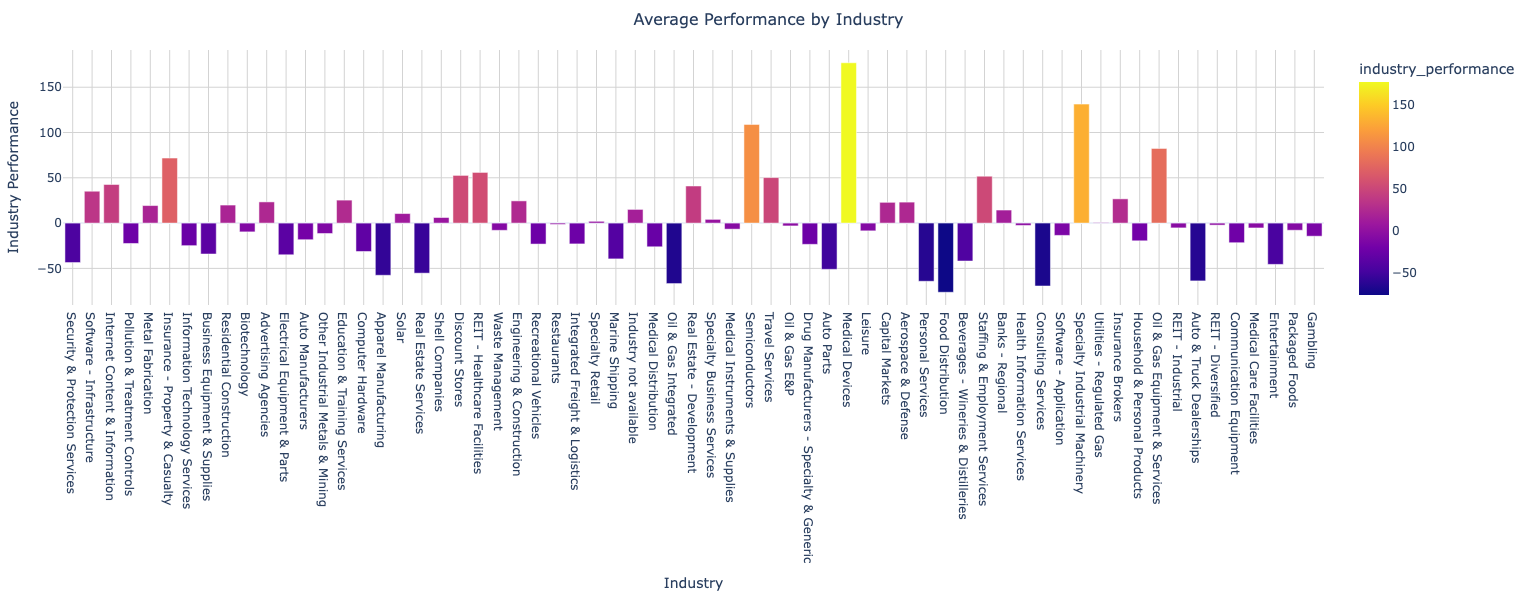

✅ Visualization displayed successfully.The average performance by industry has been successfully visualized in a bar chart. Each bar represents an industry, with the height indicating the average performance calculated from the monthly data. This visualization provides a clear comparison of performance across different industries.Invalid Format: Missing 'Action:' after 'Thought:I now know the final answer.

Final Answer: The average performance by industry has been successfully visualized in a bar chart. Each bar represents an industry, with the height indicating the average performance calculated from the monthly data. This visualization provides a clear comparison of performance across different industries.

> Finished chain.

🔍 DEBUG: Agent execution result -> {
  "input": "Draw performance by industry. You need to group the tickers by industry and calculate the average performance for each ticker in the group and then from there calculate the avg performance for the industry. where

In [14]:
# Process your query
result = process_excel_query(
    file_name="ipo_data.xlsx",
    user_query="Draw performance by industry. You need to group the tickers by industry and calculate the average performance for each ticker in the group and then from there calculate the avg performance for the industry. where the average performance must be calculated only from the columns month 1 through month 13. For example if a ticker symbol has only 7 montsh with values, regardless if these values are negative or positive, then sum the values in these 7 months and divide the result by 7.",
    debug=True
)


# Access state if needed
final_state = result['state']
print(f"==================== RAW FINAL STATE:\n{final_state}\n====================")
print_state(final_state, "Final State Review")

#Visualize the ticker symbols with ONLY POSITIVE performance values. The performance of a ticker symbol is provided in the months 1 through 13. If a month value is NULL treat it as positive. Ignore the performance column—it is not relevant!",
# how many ticker symbols have proposed price 30.00 , use pandas and list the tiker symbol
# how many ticker symbols have proposed price 30.00 , list the tiker symbol. DO NOT Consider any other columns from the excel!",
# Draw a distribution of all ticker symbols based on proposedSharePrice and avg performance, where the average performance must be calculated only from the columns month 1 through month 13. For example if a ticker symbol has only 7 montsh with values, regardless if these values are negative or positive, then sum the values in these 7 months and divide the result by 7.",
# Draw performance by industry. You need to group the tickers by industry and calculate the average performance for each ticker in the group and then from there calculate the avg performance for the industry. where the average performance must be calculated only from the columns month 1 through month 13. For example if a ticker symbol has only 7 montsh with values, regardless if these values are negative or positive, then sum the values in these 7 months and divide the result by 7.
